In [35]:
import cv2
import numpy as np
import pickle
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
import time
import torch
import torchvision.transforms as transforms

from captum.attr import IntegratedGradients

In [82]:
not_found = pickle.load( open( "../data/not_found.p", "rb" ) )

In [83]:
mtcnn = MTCNN(image_size=(218,178), margin=0)

In [84]:
not_found_by_both = []

In [85]:
frames_tracked = []
confs = []
for i, pic_path in enumerate(not_found):
    if i == 100 :
        break
    print('\rTracking frame: {}'.format(i + 1), end='')
    pic = Image.open(pic_path)
    # Detect faces
    boxes, conf = mtcnn.detect(pic)
    
    # Draw faces
    frame_draw = pic.copy()
    draw = ImageDraw.Draw(frame_draw)
    if boxes is not None:
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    else:
        not_found_by_both.append(pic_path)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((218, 178), Image.BILINEAR))
    confs.append(conf)
print('\nDone')


Tracking frame: 100
Done


In [86]:
len(not_found_by_both)

3

In [87]:
len(not_found)

5609

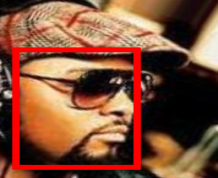

array([0.999194324016571], dtype=object)

In [89]:



for i,frame in enumerate(frames_tracked):
    if i == 2:
        break
    display.display(frame)
    display.display(confs[i])
    time.sleep(1)
    display.clear_output(wait=True)
    

In [90]:
input_image = torch.randn(1, 3, 160, 160)


In [92]:
mtcnn.eval()
integrated_gradients = IntegratedGradients(mtcnn)

In [104]:
pic = Image.open(not_found[0])

transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize the image to the desired size
    transforms.ToTensor(),  # Convert the PIL image to a PyTorch tensor
])

# Apply the transformations to the image and add a batch dimension
input_image = transform(pic).unsqueeze(0)


In [105]:
def tensor_to_pil(tensor_image):
    # Move the channel axis to the end and convert the values back to the range [0, 255]
    img_array = np.moveaxis(tensor_image.numpy() * 255, 0, -1)
    
    # Convert the NumPy array back to a PIL image and return it
    return Image.fromarray(img_array.astype(np.uint8))

# Apply the transformations to the image and add a batch dimension
input_image = transform(pic).unsqueeze(0)

def wrapper_forward_func(input_image):
    pil = tensor_to_pil(input_image)
    output = mtcnn.detect(pil)
    if len(output[0]) > 1:
        return 1  # Change this index to the desired output in the tuple
    else:
        return 0
    


In [107]:
integrated_gradients = IntegratedGradients(wrapper_forward_func)

In [108]:
attributions = integrated_gradients.attribute(input_image, target=0)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [48]:
mtcnn.detect(pic)

(array([[42.9163818359375, 80.073974609375, 122.6549301147461,
         176.32073974609375]], dtype=object),
 array([0.999288022518158], dtype=object))

In [64]:
from facenet_pytorch import InceptionResnetV1

# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval()



In [65]:
from captum.attr import Occlusion
from captum.attr import visualization as viz
from captum.attr import GradientShap